# Make buoy data file

Standardize buoy data and put it together in a Pandas dataframe.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import date2num
import numpy as np
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean.cm as cmo
import os
from collections import OrderedDict
from datetime import datetime, timedelta
import datedelta

In [278]:
base = 'drive_data/'

In [281]:
# read in buoy info
bys = pd.read_csv(base + 'buoys.csv', index_col=0).to_dict('index')

buoys = {'BOLI': {'ll': ([-94.783, 29.342]), 'color': '#689F38', 'vars': ['WaterT [deg C]', 'Depth [m]', 'Salinity']},
         'MIDG': {'ll': ([-94.875, 29.508]),  'color': '#FBC02D', 'vars': ['WaterT [deg C]', 'Depth [m]', 'Salinity']},
         'FISH': {'ll': ([-94.854, 29.670]),  'color': '#F57C00', 'vars': ['WaterT [deg C]', 'Depth [m]', 'Salinity']},
         'TRIN': {'ll': ([-94.746, 29.661]),  'color': '#FFA000', 'vars': ['WaterT [deg C]', 'Depth [m]', 'Salinity']},
         'OLDR': {'ll': ([-94.783, 29.833]), 'color': '#D32F2F', 'vars': ['WaterT [deg C]', 'Depth [m]', 'Salinity']},
         '8771486': {'ll': ([bys['8771486']['lon'], bys['8771486']['lat']]),  'color': '#0097A7',
                     'vars': ['Water Level [m]', 'AirT [deg C]', 'WaterT [deg C]', 'East [m/s]', 'North [m/s]']},
         '8770613': {'ll': ([bys['8770613']['lon'], bys['8770613']['lat']]),  'color': '#E64A19',
                     'vars': ['Water Level [m]', 'AirT [deg C]', 'WaterT [deg C]', 'East [m/s]', 'North [m/s]', 'Salinity']},
         '8771013': {'ll': ([bys['8771013']['lon'], bys['8771013']['lat']]), 'color': '#AFB42B',
                     'vars': ['Water Level [m]', 'AirT [deg C]', 'WaterT [deg C]', 'East [m/s]', 'North [m/s]', 'Salinity']},
         '8771341': {'ll': ([bys['8771341']['lon'], bys['8771341']['lat']]), 'color': '#388E3C',
                     'vars': ['Water Level [m]', 'AirT [deg C]', 'WaterT [deg C]', 'East [m/s]', 'North [m/s]',
                             'AtmPr [MB]']},
         '8771450': {'ll': ([bys['8771450']['lon'], bys['8771450']['lat']]), 'color': '#00796B',
                     'vars': ['Water Level [m]', 'AirT [deg C]', 'WaterT [deg C]', 'East [m/s]', 'North [m/s]',
                             'AtmPr [MB]']},
         'B': {'ll': ([bys['B']['lon'], bys['B']['lat']]), 'color': '#303F9F',
                     'vars': ['AirT [deg C]', 'WaterT [deg C]', 'East [m/s]', 'North [m/s]', 'Salinity', 'Along [cm/s]', 'Across [cm/s]']},
         'g06010': {'ll': ([bys['g06010']['lon'], bys['g06010']['lat']]), 'color': '#388E3C',
                     'vars': ['Along [cm/s]', 'Across [cm/s]', 'WaterT [deg C]']},
         '42035': {'ll': ([bys['42035']['lon'], bys['42035']['lat']]), 'color': '#5D4037',
                     'vars': ['AirT [deg C]', 'WaterT [deg C]', 'East [m/s]', 'North [m/s]']},
         '8770808': {'ll': ([bys['8770808']['lon'], bys['8770808']['lat']]), 'color': '#512DA8',
                     'vars': ['Water Level [m]', 'AirT [deg C]', 'WaterT [deg C]', 'East [m/s]', 'North [m/s]']},
         '8770777': {'ll': ([bys['8770777']['lon'], bys['8770777']['lat']]), 'color': '#C2185B',
                     'vars': ['Water Level [m]', 'AirT [deg C]', 'WaterT [deg C]', 'East [m/s]', 'North [m/s]']},
         '8770822': {'ll': ([bys['8770822']['lon'], bys['8770822']['lat']]), 'color': '#455A64',
                     'vars': ['Water Level [m]', 'AirT [deg C]', 'WaterT [deg C]', 'East [m/s]', 'North [m/s]']},
         '8770971': {'ll': ([bys['8770971']['lon'], bys['8770971']['lat']]), 'color': '#7B1FA2',
                     'vars': ['Water Level [m]', 'AirT [deg C]', 'WaterT [deg C]', 'East [m/s]', 'North [m/s]']},
         '8771972': {'ll': ([bys['8771972']['lon'], bys['8771972']['lat']]), 'color': '#0288D1',
                     'vars': ['Water Level [m]', 'AirT [deg C]', 'WaterT [deg C]', 'East [m/s]', 'North [m/s]']}
        }


buoys_ordered = ['8770777', '8770613', 'OLDR', 'FISH', 'TRIN', 'MIDG', '8771013', 'BOLI', 'g06010', '8771341',
                '8771450', '8771486', '8771972', '8770971', '8770808', 'B', '42035', '8770822']
# buoys down main bay
buoys_main = ['8770613', 'FISH', 'TRIN', 'MIDG', '8771013', 'BOLI', 'g06010', '8771341', '8771450']

In [282]:
savename = base + 'data.csv'
dstart = '2017-06-01'; dend = '2017-12-31'
tz = 'UTC'  # 'US/Central'
baseurl = 'http://pong.tamu.edu/'  # or 'http://localhost/'


In [283]:
if not os.path.exists(savename):
            
    ## River inflow to Trinity Bay ##
    # https://txpub.usgs.gov/txwaterdashboard/index.html
    # direct link, read in as local time
#     station = '08067252'  # '08067070'
#     url = 'https://nwis.waterdata.usgs.gov/usa/nwis/uv/?cb_00060=on&cb_00065=on&format=rdb&site_no=' + station + '&period=&begin_date=' \
#             + dstart + '&end_date=' + dend
#     river = pd.read_table(url, parse_dates=True, skiprows=29, header=None, usecols=[2,4], index_col=0,
#                      names=['Dates [UTC]', station + ': Trinity flow rate [m^3/s]'])[dstart:dend].tz_localize('US/Central', ambiguous=True).tz_convert('UTC')
#     river = river*0.3048**3  # to m^3/s
#     river = river.resample('1H', base=0).mean()
#     df = pd.DataFrame(index=river.index, data=river)
    df = pd.read_csv('drive_data/data-partial.csv', parse_dates=True, index_col=0, usecols=[0,1]).tz_localize('UTC')
    
    ## TWDB ##
    names = ['FISH', 'MIDG', 'OLDR', 'TRIN', 'BOLI']
    Files = ['seawater_salinity', 'water_depth_nonvented', 'water_temperature']
    filenames = ['Salinity', 'Depth [m]', 'WaterT [deg C]']
    base = 'https://waterdatafortexas.org/coastal/api/stations/' 
    for name  in names:
        for File, filename  in zip(Files, filenames):
            # read in as UTC
            url = base + name + '/data/' + File + '?output_format=csv&binning=hour'
            dft = pd.read_csv(url, index_col=0,
                             parse_dates=True, comment='#', header=0, names=['dates [local]', filename])[dstart:dend].tz_localize('UTC')
            dft = dft.resample('1H', base=0).mean()
            df[name + ': ' + filename] = dft
    
    ## TABS ##
    for table in ['met', 'salt', 'ven']:
        url = baseurl + 'tabswebsite/subpages/tabsquery.php?Buoyname=B&table=' + table + '&Datatype=download&units=M&tz=UTC&model=False&datepicker='
        url += dstart + '+-+' + dend
        dft = pd.read_table(url, parse_dates=True, index_col=0, na_values=-999)[dstart:dend].tz_localize('UTC')
        dft = dft.resample('1H', base=0).mean()
        for var in buoys['B']['vars']:
            if var in dft.columns:
                df['B: ' + var] = dft[var]
        
    
    ## NOS/NDBC buoys ##
    for buoy in buoys:
        if len(buoy) < 5 or buoy == 'g06010':
            continue
        url = baseurl + 'tabswebsite/subpages/tabsquery.php?Buoyname=' + buoy + '&Datatype=download&units=M&tz=UTC&model=False&datepicker='
        url += dstart + '+-+' + dend
        dft = pd.read_table(url, parse_dates=True, index_col=0, na_values=-999)[dstart:dend].tz_localize('UTC')
        dft = dft.resample('1H', base=0).mean()
        for var in buoys[buoy]['vars']:
            if var in dft.columns:
                df[buoy + ': ' + var] = dft[var]
    
    ## Vertical datum
    # The vertical datum for the bathymetry is mean high water (in file "Galveston_DEM_metadata.html"). 
    # The sea level measurements that I use are in mean sea level, so need to adjust.
    # using station datum information from e.g. https://tidesandcurrents.noaa.gov/datums.html?id=8771013
    df['8771013: Water Level [m]'] -= (1.610 - 1.467)  # MHW - MSL datums, meters
    df['8771341: Water Level [m]'] -= (3.249 - 3.072)  # MHW - MSL datums, meters
    df['8770777: Water Level [m]'] -= (2.140 - 1.951)  # MHW - MSL datums, meters
    df['8770613: Water Level [m]'] -= (1.967 - 1.807)  # MHW - MSL datums, meters
    df['8771450: Water Level [m]'] -= (1.739 - 1.588)  # MHW - MSL datums, meters
    df['8771486: Water Level [m]'] -= (6.311 - 6.183)  # MHW - MSL datums, meters
    df['8771972: Water Level [m]'] -= (1.621 - 1.498)  # MHW - MSL datums, meters
    df['8770971: Water Level [m]'] -= (1.425 - 1.259)  # MHW - MSL datums, meters
    df['8770808: Water Level [m]'] -= (4.462 - 4.299)  # MHW - MSL datums, meters
    df['8770822: Water Level [m]'] -= (1.507 - 1.308)  # MHW - MSL datums, meters
    
    
    ## currents with depth in entrance channel ##
    # have to loop over each month
    url = 'https://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?service=SOS&request=GetObservation&version=1.0.0&observedProperty=sea_water_speed&direction_of_sea_water_velocity&offering=urn:ioos:station:NOAA.NOS.CO-OPS:g06010&responseFormat=text/csv&eventTime='
    # along-channel direction
    diralong = 90 - bys['g06010']['angle']
    if diralong < 0:
        diralong += 360
    
    dst = pd.Timestamp(dstart)
    while dst < pd.Timestamp('2017-12-31'):
        dst += datedelta.MONTH  # skip first month because missing first half of data
        den = dst + datedelta.MONTH - pd.Timedelta('1 hour')

        # read in data for month
        d = pd.read_csv(url + dst.strftime('%Y-%m-%dT00:00:00Z/') + den.strftime('%Y-%m-%dT%H:%M:%SZ'), parse_dates=True, index_col=4).tz_localize('UTC')
        d = d[['sea_water_speed (cm/s)', 'direction_of_sea_water_velocity (degree)', 'sea_water_temperature (C)', 'bin_distance (m)']]

        # pivot to get times as rows and depths as columns
        d = pd.pivot_table(d, index=['bin_distance (m)', 'date_time'] )
        depths = d.index.get_level_values(0).drop_duplicates().get_values()

        # initialize columns
        if not 'g06010: Along [cm/s], depth ' + str(depths[0]) + ' [m]' in df.columns:
            for depth in depths:
                df['g06010: Along [cm/s], depth ' + str(depth) + ' [m]'] = np.nan
                df['g06010: Across [cm/s], depth ' + str(depth) + ' [m]'] = np.nan
                df['g06010: WaterT [deg C]'] = np.nan

        # calculations
        for depth in depths:

            theta = d.loc[depth]['direction_of_sea_water_velocity (degree)'].copy()
            # convert to math angles
            theta = 90 - theta
            theta[theta<0] += 360

            # calculate u and v
            east = d.loc[depth]['sea_water_speed (cm/s)']*np.cos(np.deg2rad(theta))
            north = d.loc[depth]['sea_water_speed (cm/s)']*np.sin(np.deg2rad(theta))

            # calculate along and across velocity
            df['g06010: Along [cm/s], ' + 'depth ' + str(depth) + ' [m]'].loc[dst.isoformat():den.isoformat()] = (east*np.cos(np.deg2rad(diralong)) + north*np.sin(np.deg2rad(diralong))).resample('1H', base=0).mean()
            df['g06010: Across [cm/s], ' + 'depth ' + str(depth) + ' [m]'].loc[dst.isoformat():den.isoformat()] = (-east*np.sin(np.deg2rad(diralong)) + north*np.cos(np.deg2rad(diralong))).resample('1H', base=0).mean()
        df['g06010: WaterT [deg C]'].loc[dst.isoformat():den.isoformat()] = d.loc[depth]['sea_water_temperature (C)'].resample('1H', base=0).mean()
            

    df.tz_localize(None).to_csv(savename)

In [147]:
# Add in other river gauges
# shows gauges: https://stn.wim.usgs.gov/fev/#HarveyAug2017; shows precip: https://txpub.usgs.gov/txwaterdashboard/index.html
# list: https://waterdata.usgs.gov/tx/nwis/current/?type=precip&group_key=county_cd
# USGS 08078000 Chocolate Bayou nr Alvin, TX ,; USGS 08077600 Clear Ck nr Friendswood, TX; 
# USGS 08067525 Goose Ck at Baytown, TX; USGS 08070200 E Fk San Jacinto Rv nr New Caney, TX
stations = ['08078000', '08077600', '08067525']#, '08070200']
for station in stations:
    url = 'https://nwis.waterdata.usgs.gov/tx/nwis/uv/?cb_00060=on&format=rdb&site_no=' + station \
            + '&period=&begin_date=' + dstart + '&end_date=' + dend

    river = pd.read_table(url, parse_dates=True, skiprows=29, header=None, usecols=[2,4], index_col=0,
                     names=['Dates [UTC]', station + ': flow rate [m^3/s]'])[dstart:dend].tz_localize('US/Central', ambiguous=True).tz_convert('UTC')
    river = river*0.3048**3  # to m^3/s
    river = river.resample('1H', base=0).mean()
    df[river.columns[0]] = river

KeyError: '2017-06-01'

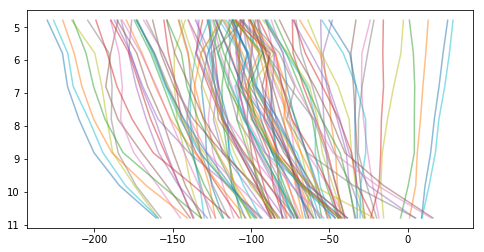

In [255]:
plt.figure(figsize=(8,4))
dates = df['2017-8-27':'2017-8-31'].index
# dates = df.index
s = np.zeros((len(dates), len(depths)))
for i, date in enumerate(dates):
    for j, depth in enumerate(depths):
        s[i,j] = df['g06010: Along [cm/s], depth %s [m]' % depth].loc[date]
plt.plot(s[:,1:].T, depths[1:], '-', alpha=0.5)
#     plt.vlines(s.mean(), depths[0], depths[-1])
plt.gca().invert_yaxis() 

In [207]:
kappa = 0.41  # von karman
# z0 = 3  # bottom roughness
nu = 0.0000010533  # m2/s
dudz = (s[:,-2] - s[:,-1])*(depths[-2] - depths[-1])
ustar = np.sqrt(nu * dudz)


lhs = s[0,:]/ustar[0]  # u/u*
rhs = 1/kappa * np.log(depths*ustar[0]/nu)


/Users/kthyng/miniconda3/envs/cart/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


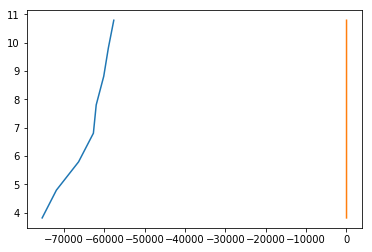

In [208]:
plt.plot(lhs, depths)
plt.plot(rhs, depths)

In [236]:
# extrapolate straight up and down for each profile
newdepths = np.concatenate((np.array([0.81, 1.81, 2.81]), depths, np.array([11.79])))
newdepths
news = np.zeros((s.shape[0], newdepths.size))
for i in range(s.shape[0]):
    news[i,:] = np.concatenate((np.ones(6)*s[i,0], s[i,3:], np.array([s[i,-1]/1.5])))
news

array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

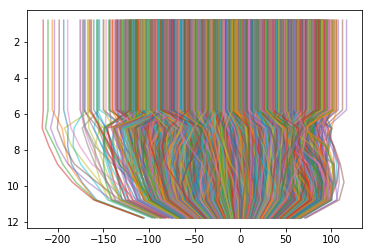

In [237]:
plt.plot(news.T, newdepths, '-', alpha=0.5)
#     plt.vlines(s.mean(), depths[0], depths[-1])
plt.gca().invert_yaxis() 

In [238]:
# calculate mean of this
means = [new.mean() for new in news]
df['mean along'] = means

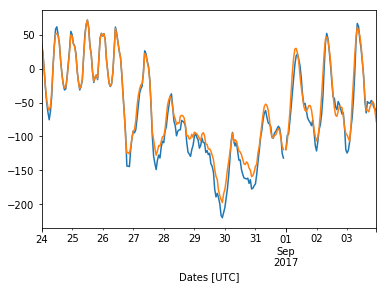

In [239]:
ax = df['g06010: Along [cm/s], depth 5.79 [m]']['2017-8-24':'2017-9-3'].plot()
df['mean along']['2017-8-24':'2017-9-3'].plot()

In [240]:
df.tz_localize(None).to_csv('drive_data/data_new.csv')

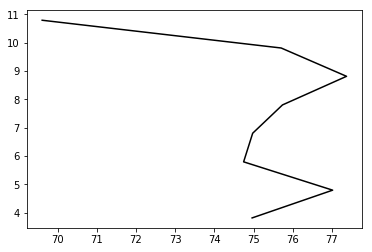

In [251]:
# try fitting and extrapolating line
plt.plot(s[820,:], depths, 'k')

In [244]:
s.shape

(5137, 8)

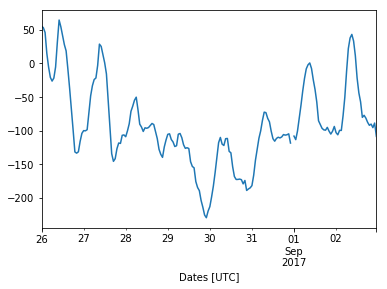

In [82]:
df['g06010: Along [cm/s], depth 4.79 [m]']['2017-8-26':'2017-9-2'].plot()

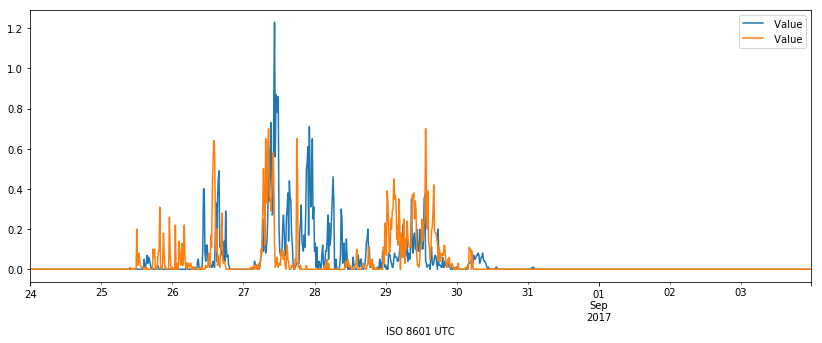

In [274]:
# precipitation data
rain = pd.read_csv('drive_data/Precipitation.Precipitation@08067000.20170601.csv', comment='#', parse_dates=True, index_col=0, usecols=[0,2])
rain2 = pd.read_csv('drive_data/Precipitation.Precipitation@08077650.20170601.csv', comment='#', parse_dates=True, index_col=0, usecols=[0,2])
ax = rain['2017-8-24':'2017-9-3'].plot()
rain2['2017-8-24':'2017-9-3'].plot(ax=ax, figsize=(14,5))

In [260]:
pd.read_csv?